In [5]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sys.path.append(os.path.abspath(".."))

from eda.models import ConversationLine, Generation
from eda.parsing import Conversations, Participants
from eda.utils import FOLDER_DIR

participants = Participants()
conversations = Conversations(participants)

ML_THEMES_BY_CONVERSATION_PATH = FOLDER_DIR / "data" / "themes_by_generation.json"

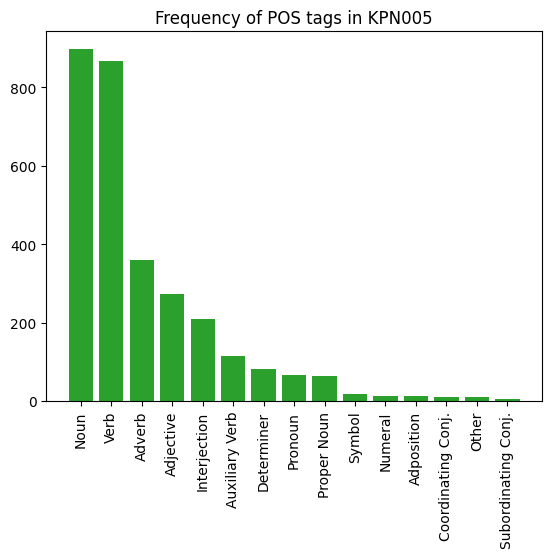

In [2]:
from collections import defaultdict
from collections.abc import Iterable


def pos_with_counts(lines: Iterable[ConversationLine]) -> tuple[list[str], list[int]]:
    text_by_pos = defaultdict(list)
    for line in lines:
        line: ConversationLine
        tagged_text = line.tagged
        for text in tagged_text:
            text_by_pos[text.pos_name].append(text)

    pos_labels, counts = zip(
        *(
            (pos, len(texts))
            for pos, texts in sorted(
                text_by_pos.items(), key=lambda pair: len(pair[1]), reverse=True
            )
        )
    )
    return list(pos_labels), list(counts)


conversation = conversations.conversation("KPN005")
pos_labels, counts = pos_with_counts(conversation.lines)
plt.bar(pos_labels, counts, color="C2")
plt.xticks(rotation=90)
plt.title(f"Frequency of POS tags in {conversation.code}")
plt.show()

In [2]:
conversations.read_all(parallel=True, load_tagged=True)

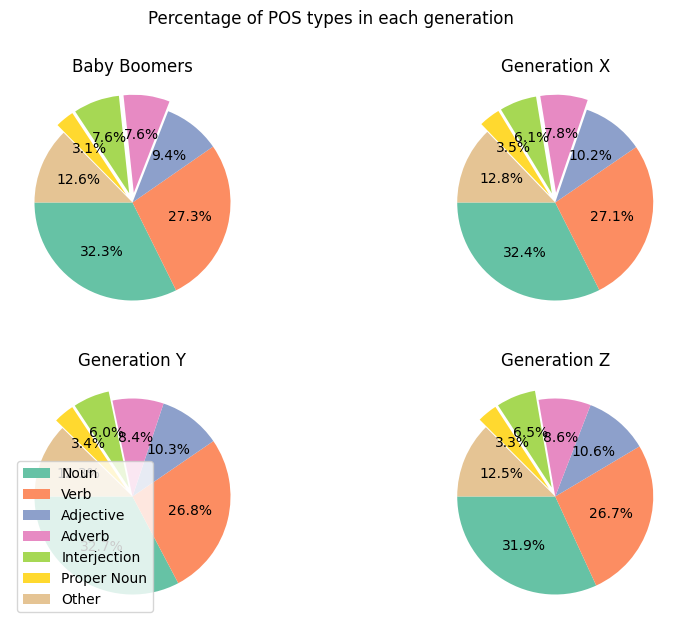

In [4]:

from eda.utils import round_precise

lines_by_generation = {
    Generation.BOOMERS: [],
    Generation.X: [],
    Generation.Y: [],
    Generation.Z: [],
}

for conversation in conversations:
    for line in conversation.lines:
        generation = line.participant.generation
        lines_by_generation[generation].append(line)


def normalise_counts(
    pos_labels: list[str], counts: list[int], top_n: int = 4
) -> tuple[list[str], list[float]]:
    new_counts = [counts[i] for i in range(top_n)]
    new_pos_labels = [pos_labels[i] for i in range(top_n)]
    new_counts.append(sum(counts[top_n:]))
    new_pos_labels.append("Other")

    total = sum(new_counts)
    new_counts = [round_precise(count / total * 100, 1) for count in new_counts]
    return new_pos_labels, new_counts


top_n = 6
colours = sns.color_palette("Set2")
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flat

pos_labels = None
for ax, (generation, lines) in zip(axes, lines_by_generation.items()):
    pos_labels, counts = normalise_counts(*pos_with_counts(lines), top_n=top_n)
    explode = [0.1 * (count < 8) for count in counts]
    ax.set_title(generation.name)
    ax.pie(counts, explode=explode, autopct="%1.1f%%", colors=colours, startangle=180)

assert pos_labels is not None
axes[2].legend(labels=pos_labels, loc="lower left", fontsize=10)

plt.suptitle("Percentage of POS types in each generation")
plt.show()

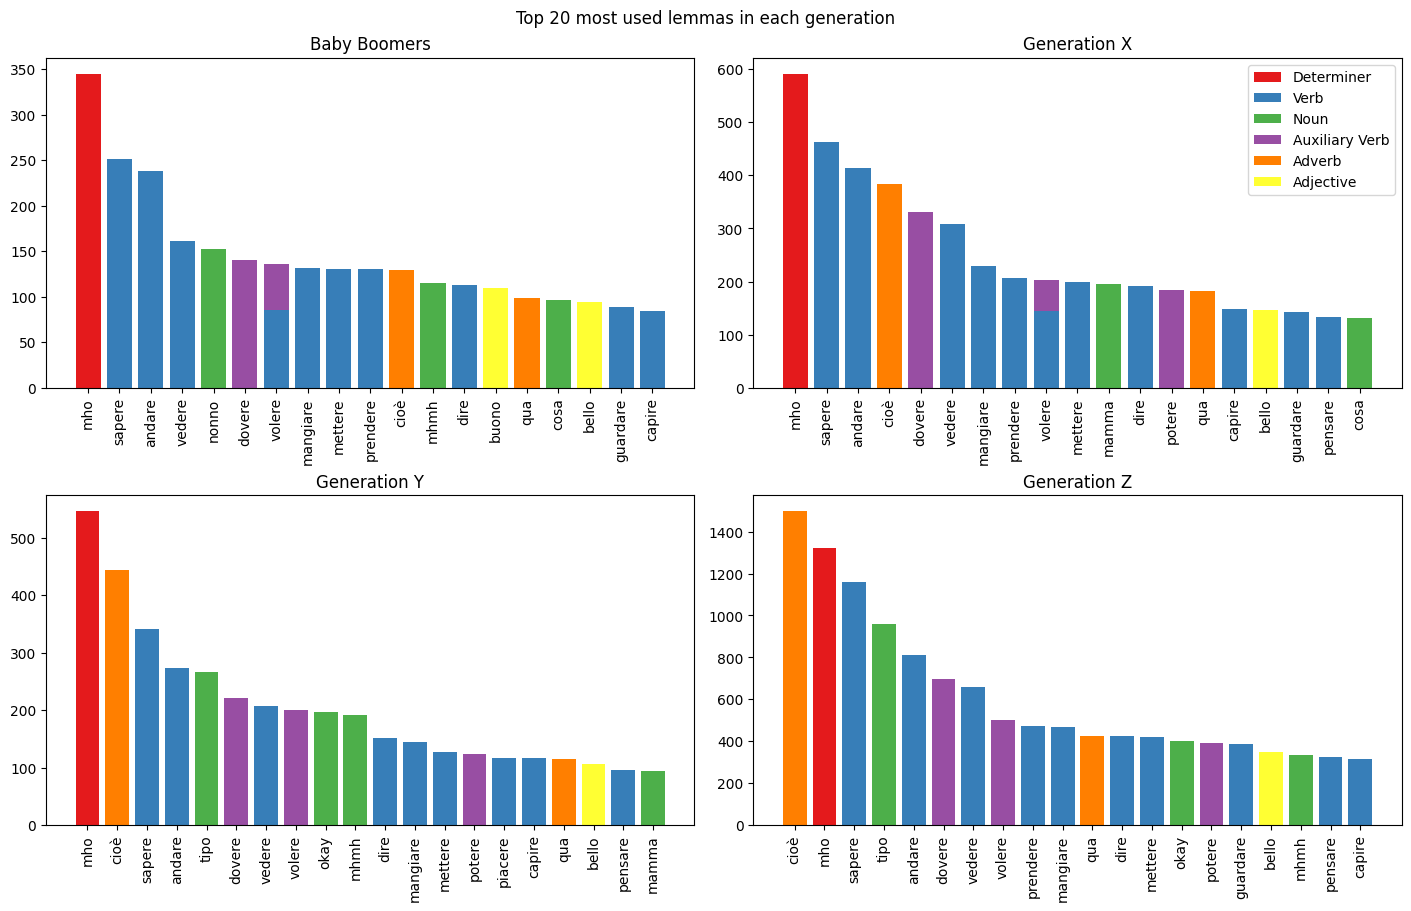

In [ ]:
from collections import Counter
from collections.abc import Sequence
from dataclasses import dataclass
from typing import Optional

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.patches import Patch

from eda.language import TaggedText
from eda.models import Generation

TOP_N_LEMMAS = 20


@dataclass(frozen=True)
class PosTaggedLemma:
    lemma: str
    pos_name: str


@dataclass(frozen=True)
class GenerationLemmaInfo:
    pt_lemmas: list[PosTaggedLemma]
    lemma_counts: list[int]
    n_total_words: int


def top_lemmas_by_generation(
    conversations,
    *,
    top_n: Optional[int] = 10,
    min_lemma_length: int = 3,
    allowed_pos_values: Optional[set] = None,
) -> dict[Generation, GenerationLemmaInfo]:
    text_by_generation: dict[Generation, list[TaggedText]] = Generation.create_mapping()

    for conversation in conversations:
        for line in conversation:
            generation = line.participant.generation
            text_by_generation[generation].extend(line.tagged)

    lemmas_by_generation = {}
    for generation, words in text_by_generation.items():
        words_by_lemma = defaultdict(list)
        for word in words:
            if len(word.lemma) < min_lemma_length:
                continue
            if allowed_pos_values is not None and word.pos not in allowed_pos_values:
                continue
            pt_lemma = PosTaggedLemma(word.lemma, word.pos_name)
            words_by_lemma[pt_lemma].append(word)

        counts = Counter({
            pt_lemma: len(group) for pt_lemma, group in words_by_lemma.items()
        })

        lemmas, frequencies = zip(*counts.most_common(top_n))
        lemmas_by_generation[generation] = GenerationLemmaInfo(
            list(lemmas), list(frequencies), len(words)
        )

    return lemmas_by_generation


def create_colour_factory(palette_name: str):
    colour_by_pos_name = {}
    palette_colours = iter(sns.color_palette(palette_name))

    def colour_pos_names(
        pos_names: Optional[Sequence[str]] = None,
    ) -> list[tuple[float, float, float]] | dict:
        if pos_names is None:
            return colour_by_pos_name

        colours = []
        for pos_name in pos_names:
            if pos_name not in colour_by_pos_name:
                colour_by_pos_name[pos_name] = colour = next(palette_colours)
            else:
                colour = colour_by_pos_name[pos_name]
            colours.append(colour)
        return colours

    return colour_pos_names


top_lemmas = top_lemmas_by_generation(
    conversations, top_n=TOP_N_LEMMAS, min_lemma_length=3
)
fig, axes = plt.subplots(2, 2, figsize=(14, 9), constrained_layout=True)
axes = axes.flat
colour_pos_names = create_colour_factory("Set1")

for ax, (generation, info) in zip(axes, top_lemmas.items()):
    pt_lemmas = info.pt_lemmas
    counts = info.lemma_counts
    lemmas, pos_names = zip(*((ptl.lemma, ptl.pos_name) for ptl in pt_lemmas))
    colours = colour_pos_names(pos_names)

    ax: Axes
    ax.set_title(generation.name)
    ax.tick_params(axis="x", labelrotation=90)
    ax.bar(lemmas, counts, color=colours)

legend_handles = [
    Patch(facecolor=color, label=pos_name)
    for pos_name, color in colour_pos_names(None).items()  # type: ignore
]
axes[1].legend(handles=legend_handles, loc="upper right")
plt.suptitle(f"Top {TOP_N_LEMMAS} most used lemmas in each generation")
plt.show()

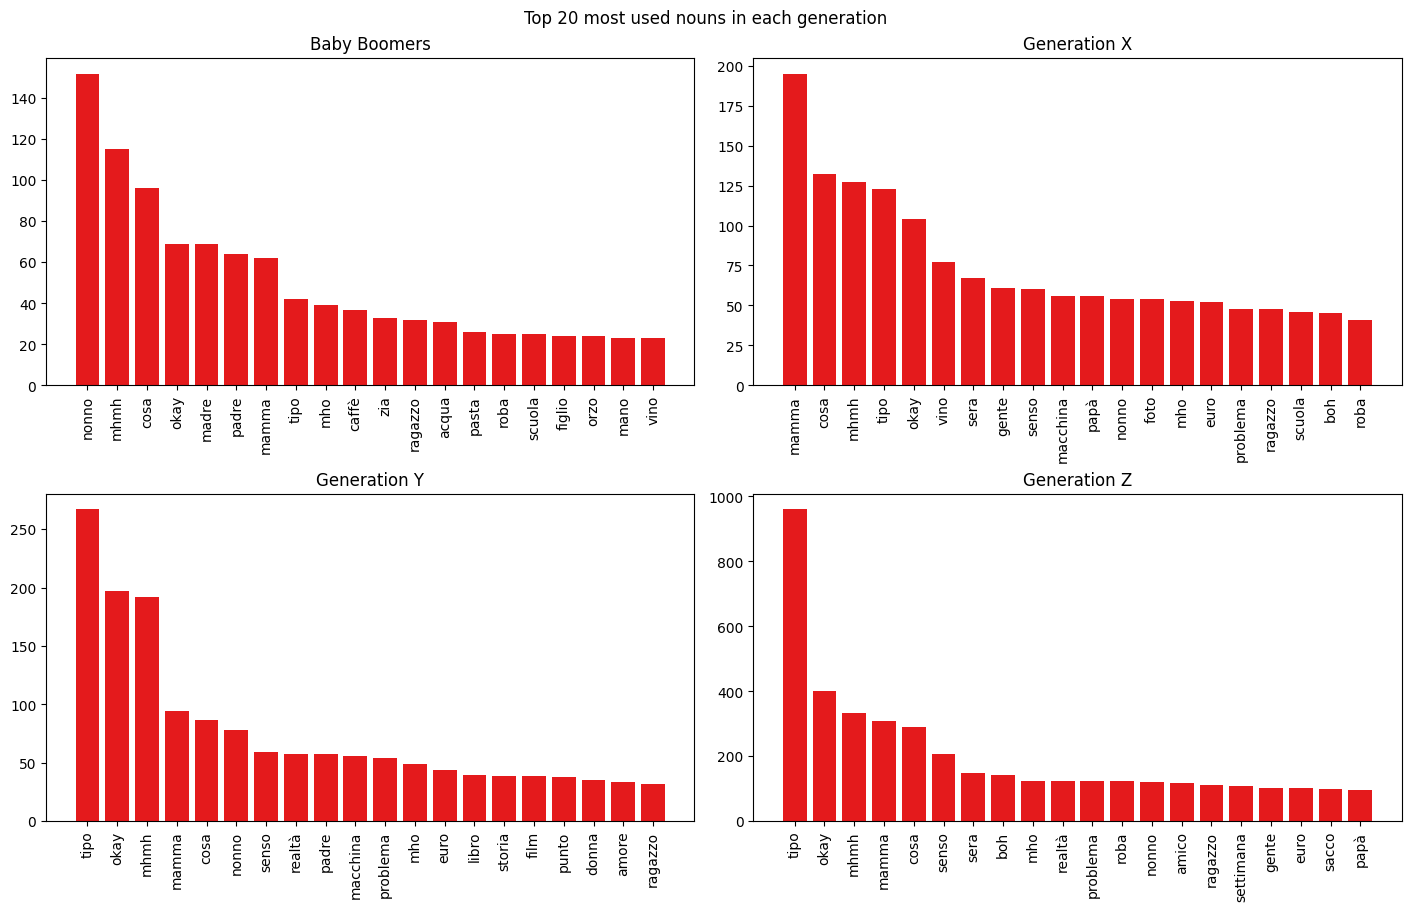

In [6]:
TOP_N_LEMMAS = 20

top_lemmas = top_lemmas_by_generation(
    conversations, top_n=TOP_N_LEMMAS, min_lemma_length=3, allowed_pos_values={"NOUN"}
)
fig, axes = plt.subplots(2, 2, figsize=(14, 9), constrained_layout=True)
axes = axes.flat
colour_pos_names = create_colour_factory("Set1")

for ax, (generation, info) in zip(axes, top_lemmas.items()):
    pt_lemmas = info.pt_lemmas
    counts = info.lemma_counts
    lemmas, pos_names = zip(*((ptl.lemma, ptl.pos_name) for ptl in pt_lemmas))
    colours = colour_pos_names(pos_names)

    ax: Axes
    ax.set_title(generation.name)
    ax.tick_params(axis="x", labelrotation=90)
    ax.bar(lemmas, counts, color=colours)

plt.suptitle(f"Top {TOP_N_LEMMAS} most used nouns in each generation")
plt.show()

## Lemma occurences
The graph of the cell below contains the intersection of all of the top 10 lemmas from each generation, hence why there are more than the specified total lemmas.

Modify the upper-snaked-cased values at the top of the cell to vary the graph output.

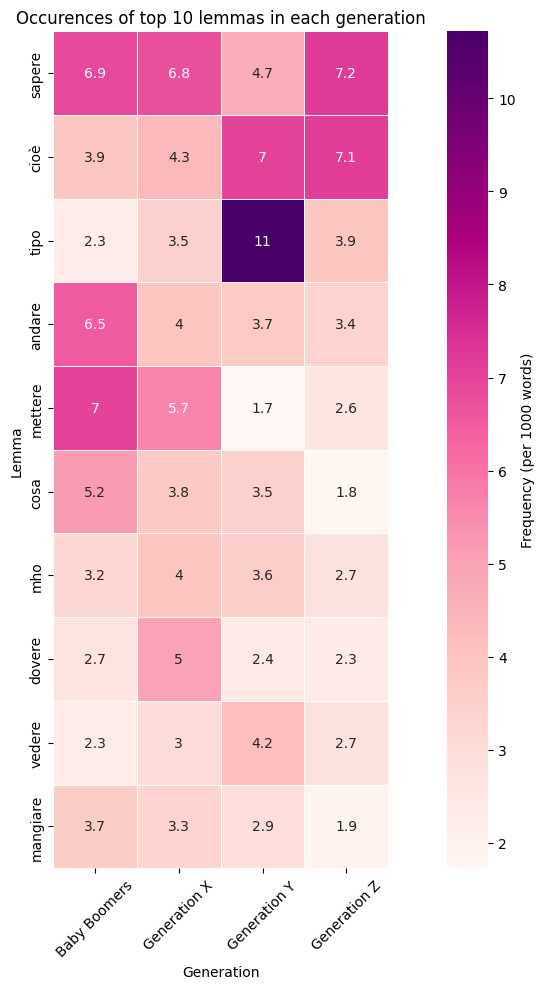

In [10]:

# Change these to produce different results
PER_WORDS = 1000
TOP_N_LEMMAS = 10
ALLOWED_POS_VALUES = None  # all are allowed
# ALLOWED_POS_VALUES = {"NOUN"}  # alt: nouns only

top_lemmas = top_lemmas_by_generation(
    conversations, top_n=None, allowed_pos_values=ALLOWED_POS_VALUES
)

records = []
for generation, info in top_lemmas.items():
    pt_lemmas = info.pt_lemmas
    counts = info.lemma_counts
    gen_name = generation.name
    for ptl, count in zip(pt_lemmas, counts):
        lemma_frequency = round_precise((count / info.n_total_words) * PER_WORDS, 2)
        records.append((ptl.lemma, gen_name, lemma_frequency))

heatmap_df = pd.DataFrame(records, columns=["lemma", "generation", "count"])
heatmap_df = heatmap_df.pivot_table(
    index="lemma", columns="generation", values="count", fill_value=0
)
heatmap_df["total_count"] = heatmap_df.sum(axis=1)
heatmap_df = heatmap_df.sort_values(by="total_count", ascending=False)
heatmap_df = heatmap_df.head(TOP_N_LEMMAS)
del heatmap_df["total_count"]

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_df,
    cmap="RdPu",
    linewidths=0.5,
    annot=True,
    square=True,
    cbar_kws=dict(label=f"Frequency (per {PER_WORDS} words)"),
)
plt.title(f"Occurences of top {TOP_N_LEMMAS} lemmas in each generation", fontsize=12)
plt.ylabel("Lemma")
plt.xlabel("Generation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

unique_lemmas = heatmap_df[(heatmap_df > 0).sum(axis=1) == 1]
for lemma, row in sorted(unique_lemmas.iterrows(), key=lambda pair: pair[1].idxmax()):
    generation = row.idxmax()
    print(
        f"{lemma!r} appears only in the top {TOP_N_LEMMAS} lemmas for {generation} {row[generation]} times"
    )

In [3]:
conversations.read_all(parallel=True, load_tagged=True)

In [ ]:
import asyncio
import json
from functools import partial
from typing import Any, Optional

from eda.language import AttributedWord
from eda.llm import MessageFactory, ModelResponseGenerator
from eda.models import Conversation
from eda.utils import FOLDER_DIR, PROMPTS_PATH

GENERATION_ORDER = [
    Generation.BOOMERS, Generation.X, Generation.Y, Generation.Z
]

def classify_conversation_generation(conversation: Conversation):
    generations = [participant.generation for participant in conversation.participants]
    counts = Counter(generations)
    most_common, count = counts.most_common(1)[0]
    if count > len(generations) / 2:
        return most_common
    else:
        return min(generations, key=GENERATION_ORDER.index)

def read_conversation_text(conversation: Conversation) -> tuple[list[AttributedWord], list[str]]:
    words = []
    lemmas = []
    for line in conversation:
        words.extend(line.normalised_words)
        for tag in line.tagged:
            lemmas.append(tag.lemma)
        for _ in range(len(line.normalised_words) - len(lemmas)):
            lemmas.append("")
    return words, lemmas

sparql_data_path = FOLDER_DIR / "data" / "sparql_data.json"
with sparql_data_path.open() as fp:
    sparql_data = json.load(fp)

lod_themes = frozenset(map(str.title, sparql_data["conversation_types"]))
prompt_text = PROMPTS_PATH.joinpath("themes_prompt.txt").read_text()
prompt = prompt_text.replace("{themes}", ', '.join(lod_themes))

conversations.read_all()

def serialise_themes(themes_by_conversation: dict[str, Any]):
    ML_THEMES_BY_CONVERSATION_PATH.write_text(
        json.dumps(themes_by_conversation, indent=4)
    )

def try_parse_response(content: str) -> Optional[list[str]]:
    try:
        data = json.loads(content)
    except json.JSONDecodeError:
        return None
    
    if (applicable_themes := data.get("applicable_themes")) is None:
        return None
    
    if not isinstance(applicable_themes, list):
        return None

    applicable_themes = list(filter(lod_themes.__contains__, applicable_themes))
    return applicable_themes

async def generate_conversation_themes(
    *, 
    prompt: str, 
    part_size: int = 200,
    max_retries: int = 3,
    auto_serialise: bool = True
):
    themes_by_conversation = defaultdict(partial(defaultdict, list))

    data = []
    n_responses_awaiting = 0
    for conversation in conversations:
        words, lemmas = read_conversation_text(conversation)
        for i in range(0, len(words), part_size):
            part = ' '.join(words[i:i + part_size])
            corresponding_lemmas = list(filter(None, lemmas[i:i + part_size]))
            data.append((conversation, part, corresponding_lemmas))
            n_responses_awaiting += 1
    
    n_responses = 0
    factory = MessageFactory(prompt)
    async with asyncio.TaskGroup() as task_group:
        response_generator = ModelResponseGenerator(task_group)
        task_group.create_task(response_generator.run())

        for conversation, content, lemmas in data:
            await response_generator.enqueue(
                factory.create_message(
                    content,
                    code=conversation.code,
                    lemmas=lemmas,
                    retries=0
                )
            )

        while n_responses < n_responses_awaiting:
            if (response := await response_generator.poll_response()) is None:
                await response_generator.wait()
                continue
            
            if (applicable_themes := try_parse_response(response.content)) is None:
                response.metadata["retries"] += 1
                if response.metadata["retries"] < max_retries:
                    await response_generator.enqueue(response)
                else:
                    n_responses += 1
                await response_generator.wait()
                continue

            n_responses += 1
            code = response.metadata["code"]
            message: dict[str, Any] = themes_by_conversation[code]
            if "generation" not in message:
                generation = classify_conversation_generation(conversations.conversation(code))
                message["generation"] = generation.name
                
            message["values"].append({
                "themes": applicable_themes, 
                "lemmas": list(map(str, response.metadata["lemmas"]))
            })

            if auto_serialise:
                serialise_themes(themes_by_conversation)
        await response_generator.enqueue(None)
    return themes_by_conversation

themes_by_conversation = await generate_conversation_themes(prompt=prompt, part_size=200)
serialise_themes(themes_by_conversation)

Finished reading conversation texts
Begin processing themes


LLM assigned themes:  98%|█████████▊| 2140/2175 [3:30:44<03:26,  5.91s/it]]  


Only include conversations where all participants are from the same generation, and treat separate permutations of generations as separate data.

This is an error in the way the data is collected but has the upside of the results (likely) being more accurate.

There would be mistakes in filtering out specific topics from multigenerational conversations, as one speaker might have a tendency to bring up a certain topic if they are from a generation due to their experiences.

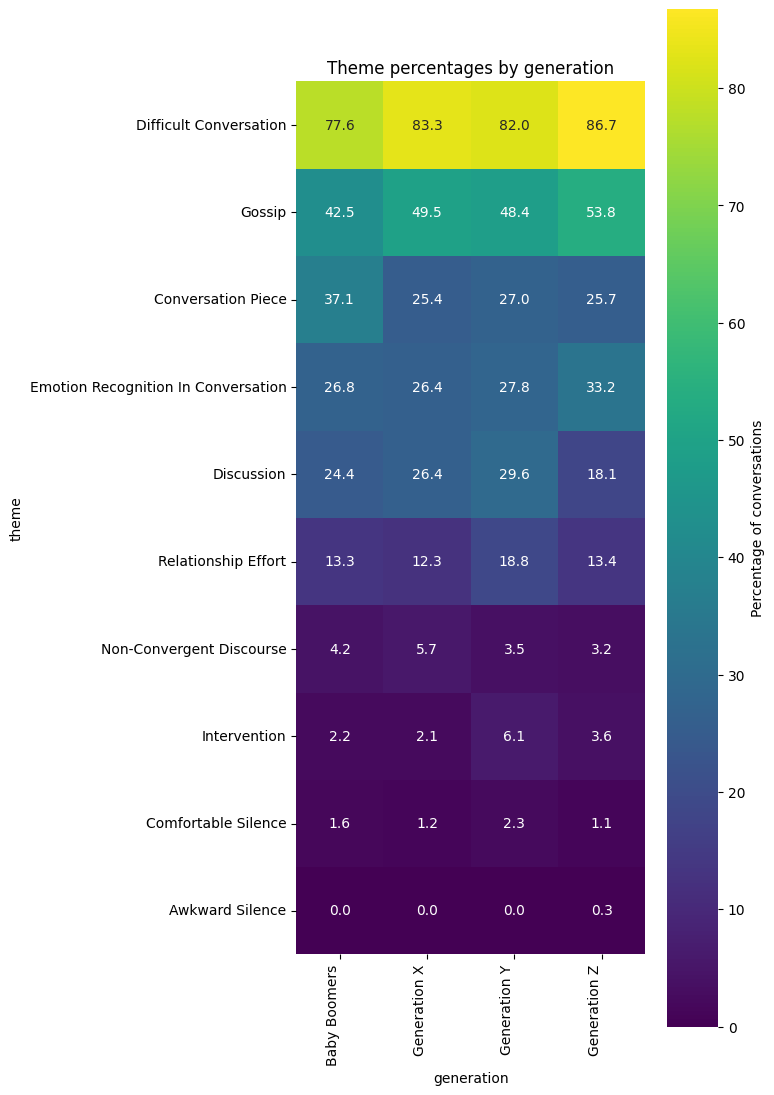

In [18]:
import json
from collections.abc import Iterable
from typing import Any

ML_THEMES_BY_CONVERSATION = json.loads(ML_THEMES_BY_CONVERSATION_PATH.read_text())

def andjoin(it: Iterable[Any], sep: str = ", ") -> str:
    *elements, last = it
    if not elements:
        return str(last)
    return f"{sep.join(map(str, elements))} and {last}"

Generation._include_range_in_str = False

generation_themes = []

for generation, themes in ML_THEMES_BY_CONVERSATION["data"].items():
    for theme, theme_data in themes.items():
        generation_themes.append(
            {"generation": generation, "theme": theme, "match": theme_data["match"]}
        )

df = pd.DataFrame(generation_themes)
df = df.pivot(index="generation", columns="theme", values="match").T.fillna(0)
df = df.loc[df.sum(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(7, 12))
sns.heatmap(
    df, 
    square=True,
    annot=True, 
    fmt=".1f",
    cmap="viridis", 
    cbar_kws={"label": "Percentage of conversations"}
)

plt.title("Theme percentages by generation")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()